In [1]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#prefer locally cached copy of SQL Server data.  If running from GitHib, unzip the RacingZone.7z
runSql = False

In [2]:
#only required in VS Code - comment out if executing in the browser
import os
os.chdir('./ExoticPinger/Jupyter/FinishingPositionProb')
os.getcwd()

'C:\\Users\\nick\\source\\repos\\ExoticPinger\\Jupyter\\FinishingPositionProb'

### Load data for each race in AU Thoroughbreds
Data is from 1 Jan 2016 and is a local cache of the data avaialble at https://www.racingzone.com.au/results/

In [3]:
resultsSql = 'SELECT * from RacingZone'
if runSql:
    cnxn = pyodbc.connect(open('credentials.xxx').readline())
    results = pd.read_sql(resultsSql,cnxn)
    results.to_csv('RacingZone.csv', index=False, date_format='%Y%m%d')

results = pd.read_csv('RacingZone.csv')
results['MeetingDate'] = pd.to_datetime(results['MeetingDate'], format="%Y%m%d")
results.head()

,RacingZoneId,MeetingName,MeetingDate,RaceNo,FinishPos,Margin,RunnerName,SP,Settled,At1200,...,At400,Comments,TrackCond,PrizeMoney,Distance,AgeSex,TrainerJockey,Gear,Weight,Barrier
0,51109,Pinjarra,2016-03-24,9,7,2.3,Skellig,46.0,10,0,...,9,NaN,GOOD3,18.0,1600m,4g,D S Pearce - C Johnston-Porter,B,58.5,10
1,51110,Pinjarra,2016-03-24,9,8,2.5,Starry Dane,31.0,6,0,...,6,NaN,GOOD3,18.0,1600m,4g,A G Durrant - Joseph Azzopardi,na,56.0,1
2,51113,Pinjarra,2016-03-24,9,11,4.5,Beckers,17.0,11,0,...,10,NaN,GOOD3,18.0,1600m,4g,A G Durrant - W Pike,na,57.0,11
3,51116,Orange,2016-03-24,1,2,1.3,The Penguin,17.0,8,0,...,7,NaN,GOOD3,15.0,1150m,4g,Ms G Williams - Aaron Sweeney,B,53.5,8
4,51118,Orange,2016-03-24,1,4,3.8,Four More Millers,31.0,2,0,...,5,NaN,GOOD3,15.0,1150m,4g,S I Singleton - Crystal Conning,na,52.0,3


## Add Betfair data
Supplement the original data with finish position data and BSP Place Data.  Data downloaded from APIs used to populate https://www.betfair.com.au/hub/racing-results/ 

In [4]:
runnersWithFinishPositionSql = \
'''
select m.MeetingName, m.MeetingDate, r.RaceNumber, rnr.RunnerNumber, rnr.RunnerName, rnr.FinishPosition,
ISNULL(TRY_CAST(json_value(r.[RawData], '$.raceLength') as float), 0) as raceLength,
rnr.BspWin
from [dbo].[BfMeeting] m  
inner join [dbo].[BfRace] r on m.BfMeetingId = r.BfMeetingId
inner join [dbo].[BfRunner] rnr on rnr.BfRaceId = r.BfRaceId
where m.[MeetingDate] >= '1 Jan 2016' and m.RaceType = 'R' and rnr.ScratchedUtc is null and json_value(m.[RawData], '$.country') = 'AUS'
'''

if runSql:
    cnxn = pyodbc.connect(open('credentials.xxx').readline())
    runnersWithFinishPosition = pd.read_sql(runnersWithFinishPositionSql,cnxn)
    runnersWithFinishPosition.to_csv('BetfairPositionData.csv', index=False, date_format='%Y-%m-%d')

#read cached copy for speed and to avoid SQL ODBC pains 
runnersWithFinishPosition= pd.read_csv('BetfairPositionData.csv')
runnersWithFinishPosition['MeetingDate'] = pd.to_datetime(runnersWithFinishPosition['MeetingDate'], format="%Y-%m-%d")

In [5]:
import re
def RunnerNameClean(name):
    name = name.lower()
    name = re.sub(r'\W+', '', name)
    return name.strip()
    

runnersWithFinishPosition['RunnerNameClean'] = runnersWithFinishPosition['RunnerName'].apply(lambda x: RunnerNameClean(x))
results['RunnerClean'] = results['RunnerName'].apply(lambda x: RunnerNameClean(x))

In [6]:
def ChangetoTabTrackName(df):
                    
    df = df.replace('MORPHETTVILLE PARKS', 'MORPHETTVILLE')
    df = df.replace('ROYAL RANDWICK', 'RANDWICK')
    df = df.replace('RANDWICK KENSINGTON', 'RANDWICK')
    df = df.replace('DEVONPORT SYNTHETIC', 'DEVONPORT')
    df = df.replace('DEVONPORT TAPETA SYNTHETIC', 'DEVONPORT')
    df = df.replace('KENSINGTON', 'RANDWICK')
    df = df.replace('GEELONG SYNTHETIC', 'GEELONG')
    df = df.replace('ROSEHILL GARDENS', 'ROSEHILL')
    df = df.replace('CANTERBURY PARK', 'CANTERBURY')
    df = df.replace('PAKENHAM SYNTHETIC', 'PAKENHAM')
    df = df.replace('ESPERANCE BAY', 'ESPERANCE')
    df = df.replace('SANDOWN HILLSIDE', 'SANDOWN')
    df = df.replace('SANDOWN-HILLSIDE', 'SANDOWN')
    df = df.replace('SANDOWN LAKESIDE', 'SANDOWN') 
    df = df.replace('SANDOWN-LAKESIDE', 'SANDOWN')
    df = df.replace('LADBROKES PARK HILLSIDE', 'SANDOWN')
    df = df.replace('LADBROKES PARK LAKESIDE', 'SANDOWN')
    df = df.replace('PINJARRA PARK', 'PINJARRA')
    df = df.replace('BALLARAT SYNTHETIC', 'BALLARAT') 
    df = df.replace('RACING.COM PARK SYN', 'PAKENHAM') 
    df = df.replace('RACING.COM PARK', 'PAKENHAM') 
    df = df.replace('PIONEER PARK', 'ALICE SPRINGS') 
    df = df.replace('KINGSCOTE', 'KANGAROO ISL')  
    df = df.replace('GEELONG SYNTHETIC', 'GEELONG') 
    df = df.replace('WAGGA RIVERSIDE', 'WAGGA') 
    df = df.replace('ASCOT PARK', 'ASCOT')
    df = df.replace('CANBERRA ACTON', 'CANBERRA')
    df = df.replace('RANDWICK INS', 'RANDWICK')
    df = df.replace('BELMONT PARK', 'BELMONT')
    df = df.replace('BALLARAT SYN', 'BALLARAT')
    df = df.replace('MT GAMBIER', 'MOUNT GAMBIER')
    df = df.replace('SPENDTHRIFT AUSTRALIA PARK', 'WERRIBEE')
    df = df.replace('BET365 PARK KILMORE', 'KILMORE')
    df = df.replace('SPORTSBET-BALLARAT', 'BALLARAT')
    df = df.replace('MURRAY BRIDGE (NOT USED)', 'MURRAY BRIDGE')
    df = df.replace('AQUIS PARK GOLD COAST', 'GOLD COAST')
    df = df.replace('CRANBOURNE-TRN', 'CRANBOURNE')
    df = df.replace('FANNIE BAY', 'DARWIN')
    df = df.replace('SUNSHINE COAST CUSHION', 'SUNSHINE COAST') 
    df = df.replace('WYNDHAM AUS', 'WYNDHAM')
    return df

In [7]:
#don't really need this - the join will knock out OS venues, but helps assess how much data is lost to dirty data and how much is expected because of OS and picnic venues
overseasAndPicnicTracks = ['NEW PLYMOUTH RACEWAY', 'EINASLEIGH',
       'BOULIA', 'GLADSTONE', 'LIGHTNING RIDGE', 'BARCALDINE',
       'EMERALD', 'NANANGO', 'BALNARRING', 'AUGATHELLA',
       'WAUCHOPE', 'SHA TIN', 'MATAMATA',
       'WANGANUI', 'HAPPY VALLEY', 'CEDUNA', 'DEEPWATER', 
       'WOOLAMAI', 'KING ISLAND', 'BURRUMBEET',
       'HANGING ROCK', 'LONGFORD', 'WALLABADAH', 'GILGANDRA',
       'MERTON', 'ELLERSLIE', 'HASTINGS', 'TULLIBIGEAL',
       'HEALESVILLE', 'AWAPUNI', 'RICCARTON PARK', 
       'PHAR LAP RACEWAY', 'PUKEKOHE PARK', 'BELL', 'INNISFAIL', 'DEDERANG', 'TAURANGA',
       'TAUHERENIKAU', 'PORT HEDLAND', 'GORDONVALE', 'CHARLEVILLE',
       'BURRANDOWAN', 'LEETON', 'HUGHENDEN', 'WARWICK', 'ARAWA PARK',
       'WINTON NZ', 'AVONDALE', 'DARGAVILLE', 'ATHERTON', 'THANGOOL', 'JULIA CREEK',
       'GRENFELL', 'HILLSTON', 'BALRANALD',
       'TE AROHA', 'BLACKALL', 'MERRIWA',
       'WINTON AUS', 'BRAIDWOOD',
       'MILES', 'BEDGERABONG', 'BUCHAN', 'TE RAPA', 'COLAC',
       'LOCK', 'TRENTHAM', 'GREYMOUTH', 
       'BUNDABERG', 'MT MAGNET', 'OAKLEY', 'QUILPIE', 'ESK', 'COBAR',
       'LONGREACH', 'WINGATUI', 'TE AWAMUTU', 'TENNANT CREEK', 
       'RUAKAKA', 'MUDGEE', 'CHARTERS TOWERS', 'BOURKE', 'SWIFTS CREEK',
       'OTAKI', 'MAREEBA', 'NYNGAN', 'CUNNAMULLA', 'HOME HILL',
       'WONDAI', 'DENILIQUIN', 'TAUPO', 'ASHBURTON',
       'KUNUNURRA', 'CAMOOWEAL', 'DINGO', 'BERRIGAN', 'BETOOTA',
       'KUMARA', 'PINGRUP', 'SPRINGSURE',
       'WANDOAN', 'TRANGIE', 'ARDLETHAN', 'ALEXANDRA',
       'HOKITIKA', 'NEWMAN', 'JUNCTION', 'WAIPUKURAU',
       'RICHMOND', 'INVERELL', 'WARRA',
       'HOLBROOK', 'MAXWELTON', 'NOORAMA', 'GOONDIWINDI', 
       'BOWEN', 'WARIALDA', 'WARREN', 'COOTAMUNDRA',
       'EIDSVOLD', 'BLUFF', 'COONABARABRAN',
       'TUMUT', 'CONDOBOLIN', 'TEXAS', 'MOULAMEIN', 'TATURA', 'ASHWOOD PARK', 
       'STREAKY BAY', 'MONTO', 'CLONCURRY', 'MORANBAH', 'GEURIE', 'MURTOA'
       'QUORN', 'MENDOORAN', 'MINGENEW',
       'PENONG', 'CROOKWELL', 'HINNOMUNJIE', 'WAVERLEY', 'BIRDSVILLE',
       'MOE', 'MT GARNET', 'GREGORY DOWNS', 'YEA', 'GORE', 'MITCHELL',
       'ARAMAC', 'LEINSTER', 'ROEBOURNE', 'MCKINLAY', 'TAROOM', 'ADELAIDE RIVER',
       'LEONORA', 'TAMBO', 'EWAN', 'YOUNG', 'JANDOWAE', 'CHINCHILLA',
       'TOMINGLEY', 'KATHERINE', 'ALPHA', 'CASTERTON', 'LAURA',
       'TUMBARUMBA', 'KOJONUP',
       'TWIN HILLS', 'MEEKATHARRA', 'ILFRACOMBE', 'ENNGONIA',
       'TE TEKO', 'BROKEN HILL', 'WYNDHAM AUS', 'MUTTABURRA', 
       'TOTTENHAM', 'KERANG', 'PENSHURST', 
       'DROUIN', 'MIDDLEMOUNT', 'TALMOI',
       'OAK PARK', 'BEDOURIE', 'CLERMONT', 'BARRABA', 'SURAT',
       'JERILDERIE', 'MUSWELLBROOK', 'LAVERTON', 'ISISFORD', 'COLLIE',
       'CLIFTON', 'ARARAT', 'ST GEORGE', 'PORT MACQUARIE', 'TALWOOD',
       'PRAIRIE', 'CARINDA', 'NARROMINE', 'MURRAY BRIDGE GH',
       'NARRANDERA', 'WALGETT', 'HAWERA', 'CORFIELD', 'ROXBY DOWNS',
       'BREWARRINA', 'INJUNE', 'GAYNDAH',
       'MALLAWA', 'MARBLE BAR', 'DEAGON', 'STAMFORD', 'MUNGINDI',
       'STAWELL', 'COOMA', 'STRATFORD', 'LOUTH', 'WEAN', 'GULGONG',
       'EDENHOPE', 'WAIROA', 'MURTOA'
       'GREAT WESTERN', 'REEFTON', 'HAMILTON', 'WOODVILLE', 'CARRATHOOL', 
       'BINGARA', 'OAKBANK', 'ALICE SPRINGS', 'FLINTON', 'TOWER HILL',
       'MORVEN', 'COLLARENEBRI', 'BINNAWAY', 'BOOROWA', 
       'QUAMBONE', 'OAMARU', 'CALLIOPE', 'COOKTOWN',
       'TABULAM', 'COLERAINE', 'GULARGAMBONE', 'COME BY CHANCE',
       'LOCKHART', 'POONCARIE', 'TARA', 'BUNDARRA', 'JUNDAH', 'JAMESTOWN',
       'MUNGERY', 'MOORA', 'BOMBALA',  'HARDEN',
       'WENTWORTH', 'KUMBIA', 'MANSFIELD', 'MT PERRY',
       'BONG BONG', 'HAY', 'PENTLAND', 'ADAMINABY',
       'GUNNEDAH', 'PENOLA', 'WYCHEPROOF', 'LANDOR',
       'MOTUKARARA', 'NHILL', 'GRIFFITH', 'CLARE', 'TOCUMWAL'
       'CAMPERDOWN', 'YALGOO', 'DONGARA', 'WATERLEA', 'THAMES']

In [8]:
runnersWithFinishPosition['MeetingName_Upper'] = runnersWithFinishPosition['MeetingName'].apply(lambda x: x.upper())
runnersWithFinishPosition['MeetingName_Upper'] = runnersWithFinishPosition['MeetingName_Upper'].apply(lambda x: ChangetoTabTrackName(x))
results['MeetingName_Upper_Res'] = results['MeetingName'].apply(lambda x: x.upper())
results['MeetingName_Upper_Res'] = results['MeetingName_Upper_Res'].apply(lambda x: ChangetoTabTrackName(x))

results = results[~results['MeetingName_Upper_Res'].isin(overseasAndPicnicTracks)]

#merge onto original DF
merged = pd.merge(results, runnersWithFinishPosition,  how='inner', left_on=['MeetingDate', 'MeetingName_Upper_Res', 'RaceNo', 'RunnerClean'], right_on = ['MeetingDate', 'MeetingName_Upper', 'RaceNumber', 'RunnerNameClean'])

#merged[merged.MeetingName_Upper.isnull()][['MeetingDate', 'MeetingName_Upper_Res', 'RaceNo', 'RunnerClean']]
#merged[merged.MeetingName_Upper.isnull()]['MeetingName_Upper_Res'].unique()

In [9]:
len(merged.index)

715836

In [10]:
#runnersWithFinishPosition[(runnersWithFinishPosition.MeetingDate == dt.datetime(2016,3,26))&(runnersWithFinishPosition.MeetingName_Upper == 'ROSEHILL')&#(runnersWithFinishPosition.RaceNumber == 5)]

In [11]:
merged.drop(['RacingZoneId', 'MeetingName_x', 'RunnerClean', 'MeetingName_y', 'RaceNumber', 'RunnerNameClean','MeetingName_Upper', 'RunnerName_y'], axis=1, inplace=True)
merged.columns

Index(['MeetingDate', 'RaceNo', 'FinishPos', 'Margin', 'RunnerName_x', 'SP',
       'Settled', 'At1200', 'At800', 'At400', 'Comments', 'TrackCond',
       'PrizeMoney', 'Distance', 'AgeSex', 'TrainerJockey', 'Gear', 'Weight',
       'Barrier', 'MeetingName_Upper_Res', 'RunnerNumber', 'FinishPosition',
       'raceLength', 'BspWin'],
      dtype='object')

In [12]:
merged.head()

,MeetingDate,RaceNo,FinishPos,Margin,RunnerName_x,SP,Settled,At1200,At800,At400,...,AgeSex,TrainerJockey,Gear,Weight,Barrier,MeetingName_Upper_Res,RunnerNumber,FinishPosition,raceLength,BspWin
0,2016-03-24,9,7,2.3,Skellig,46.0,10,0,9,9,...,4g,D S Pearce - C Johnston-Porter,B,58.5,10,PINJARRA,1,7,1600.0,4.16
1,2016-03-24,9,8,2.5,Starry Dane,31.0,6,0,6,6,...,4g,A G Durrant - Joseph Azzopardi,na,56.0,1,PINJARRA,8,8,1600.0,34.00
2,2016-03-24,9,11,4.5,Beckers,17.0,11,0,10,10,...,4g,A G Durrant - W Pike,na,57.0,11,PINJARRA,4,11,1600.0,21.00
3,2016-03-24,1,2,1.3,The Penguin,17.0,8,0,8,7,...,4g,Ms G Williams - Aaron Sweeney,B,53.5,8,ORANGE,6,2,1150.0,40.00
4,2016-03-24,1,4,3.8,Four More Millers,31.0,2,0,2,5,...,4g,S I Singleton - Crystal Conning,na,52.0,3,ORANGE,4,4,1150.0,60.88


## Quick Analysis of what a runner with 10% probability looks like

In [13]:
winProd10pct = merged[(merged.BspWin>=9.0) & (merged.BspWin<11)]
len(winProd10pct[winProd10pct.Margin == 0].index) / len(winProd10pct.index)

0.10046339626087156

In [14]:
winProd10pct['Margin'].mean()

4.030442623325037

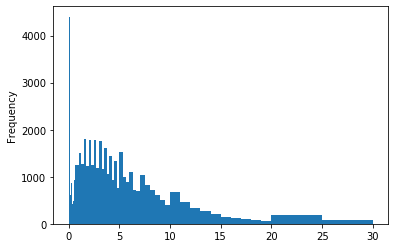

In [15]:
lengths = []
for x in range(1,100):
    lengths.append(math.log(x)/2)

manualBins = [0,0.1,0.2,0.3,0.4,0.5,0.666,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.3333,5.6666,6,6.3333,6.66666,7,7.5,8,8.5,9,9.5,10,11,12,13,14,15,16,17,18,19,20,25,30]


winProd10pct['Margin'].plot.hist(bins=manualBins)

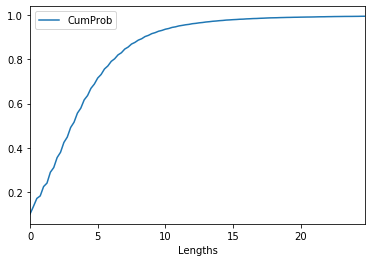

In [16]:
prob = pd.DataFrame(columns=['Lengths', 'CumProb']) 
totalLen = len(winProd10pct.index)

for x in range(0,100):
    lengths = x / 4
    prob = prob.append({'Lengths': lengths, 'CumProb' : len(winProd10pct[winProd10pct.Margin <= lengths].index) / totalLen}, ignore_index=True)


prob.plot(x='Lengths', y='CumProb', kind='line')

## Quick look at distance impacts

In [17]:
winProd10pctUnder1100 = winProd10pct[winProd10pct.raceLength < 1100].copy()
winProd10pctUnder1500 = winProd10pct[winProd10pct.raceLength < 1500].copy()
winProd10pctOver1500 = winProd10pct[winProd10pct.raceLength >= 1500].copy()
winProd10pctOver2500 = winProd10pct[winProd10pct.raceLength >= 2500].copy()

print(winProd10pctUnder1100['Margin'].mean())
print(winProd10pctUnder1500['Margin'].mean())
print(winProd10pctOver1500['Margin'].mean())
print(winProd10pctOver2500['Margin'].mean())

3.629686731179239
3.8016470049999835
4.560608814175401
7.9877934272300495
